In [1]:
!pip install tensorflow
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output


**Loading the data and creating pickle file using only one batch**


In [2]:
def load_data(file_name,pickle_name):
  f = h5py.File(file_name,"r")
  print(list(f.keys()))
  batch=f.get("batch")
  num_cells = batch['summary'].shape[0]
  bat_dict = {}
  for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()] #ici on a remplacé ".value" par "[()]", et dans toutes les lignes suivantes
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = ({'IR': summary_IR, #création d'un 1er dict avec les données "résumées", càd 1 donnée par cycle
               'QC': summary_QC, 
               'QD': summary_QD, 
               'Tavg': summary_TA, 
               'Tmin': summary_TM, 
               'Tmax': summary_TX, 
               'chargetime': summary_CT,
               'cycle': summary_CY}) 
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = ({'I': I,  
               'Qc': Qc, 
               'Qd': Qd, 
               'Qdlin': Qdlin, 
               'T': T, 
               'Tdlin': Tdlin, 
               'V':V, 
               'dQdV': dQdV, 
               't':t})
        cycle_dict[str(j)] = cd
        
    cell_dict = ({'cycle_life': cl, 
                 'charge_policy':policy, 
                  'summary': summary, 
                  'cycles': cycle_dict})
    key = 'b1c' + str(i)
    bat_dict[key]=   cell_dict


  df=pd.DataFrame(bat_dict)

  with open(pickle_name,'wb') as fp:
        pickle.dump(bat_dict,fp) 
  return df

In [3]:
batch1 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [4]:
numBat1 = len(batch1.keys())
numBat1

41

In [5]:
batch2 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch3.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [6]:

numBat2 = len(batch2.keys())
numBat2
batch3 = pickle.load(open(r'C:\Users\sarbaoui01\Desktop\Batter_dataset\batch2.pkl','rb'))

numBat3 = len(batch3.keys())
numBat3
numBat = numBat1 + numBat2 + numBat3
numBat

135

In [7]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

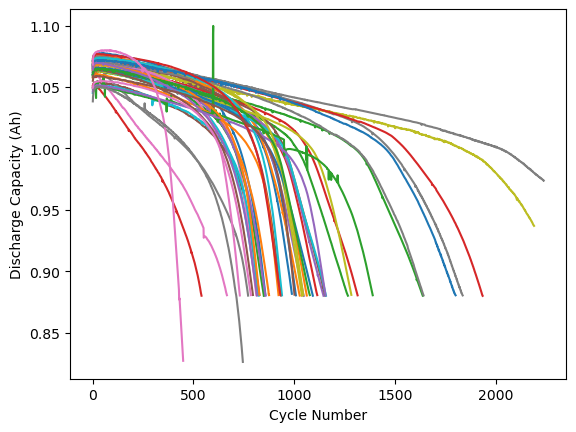

In [8]:
for i in bat_dict.keys():
  plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [9]:
bat_dict_keys = bat_dict.keys()

In [10]:
bat_dict_keys

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22', 'b1c46', 'b1c47'])

In [11]:
RUL = []

for i in bat_dict_keys:
  
    cell = bat_dict[i]
    cycle_life = int(cell['summary']['cycle'][-1])
    for j in range(1,cycle_life):
        RUL.append(cycle_life-j)

In [12]:
len(RUL)

52153

In [13]:
def linear_interpolation(x, y, start, end, x_lin):
    x = x[start:end]
    y = y[start:end]
    f = interp1d(x,y)
    datalin = f(x_lin)
    datalin = smooth_curve(datalin)
    
    return(datalin)

In [14]:
def smooth_curve(points, factor=0.6):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [15]:
cycle_vector_features = (['Idlin', 
                          'Qdlin', 
                          'Tdlin', 
                          'dQdV'])
Ic=[]
Vc=[]
Tc=[]
Id=[]
Vd=[]
Td=[]
charge_policy=[]

cycle_scalar_features = (['IR', 
                          'Tavg', 
                          'Tmin', 
                          'Tmax', 
                          'QC', 
                          'QD', 
                          'SOH', 
                          'chargetime'])



 
cycle_vector_dataset_arr = np.zeros((len(RUL), len(cycle_vector_features), 200)) 

cycle_scalar_dataset_arr = np.zeros((len(RUL), len(cycle_scalar_features))) 

cycle_dataset_arr = (np.empty((len(RUL), 
                               len(cycle_vector_features)+len(cycle_scalar_features), 
                               200))) 
cycle_dataset_arr[:] = np.NaN


cycle_vector_dataset_dict = {} 
cycle_scalar_dataset_dict = {} 
global_dataset = {} 

s=0 
for i in bat_dict_keys : 
    clear_output(wait=True)
    cell = bat_dict[i]   
    print('cell:', i) 
    cycle_life = len(cell['summary']['cycle'])
    
    for j in range(1,cycle_life):
        
       
        
        start_discharge = np.where(cell['cycles'][str(j)]['I'] < -0.05) 
        start_discharge = start_discharge[0][0]
        
        end_discharge = np.where(cell['cycles'][str(j)]['I'] < -3.9) 
        end_discharge = end_discharge[0][-1]
        
        start_charge = np.where(cell['cycles'][str(j)]['I'] > 0)
        end_charge = start_charge[0][-1]
       
        start_charge = start_charge[0][0]
        
    
        
        
        
        Vmin = min(cell['cycles'][str(j)]['V'][start_discharge:end_discharge]) 
        Vmax = max(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        Id.append(cell['cycles'][str(j)]['I'][start_discharge:end_discharge])
        Vd.append(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        Td.append(cell['cycles'][str(j)]['T'][start_discharge:end_discharge])
        
        Ic.append(cell['cycles'][str(j)]['I'][start_charge:end_charge])
        Vc.append(cell['cycles'][str(j)]['V'][start_charge:end_charge])
        Tc.append(cell['cycles'][str(j)]['T'][start_charge:end_charge])
        charge_policy.append(cell['charge_policy'])
        x_discharge = np.linspace(Vmax,Vmin,200) 
            
          
        Idlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['I'], \
                                     start_discharge, end_discharge, x_discharge)
        Qdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['Qd'], \
                                     start_discharge, end_discharge, x_discharge)
        Tdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['T'], \
                                     start_discharge, end_discharge, x_discharge)
        
        
        g = interp1d(np.linspace(Vmax,Vmin,1000), cell['cycles'][str(j)]['dQdV'])
        dQdV = g(x_discharge)
        
        
        cycle_vector_dataset_arr[s+j-1][0] = Idlin
        cycle_vector_dataset_arr[s+j-1][1] = Qdlin
        cycle_vector_dataset_arr[s+j-1][2] = Tdlin
        cycle_vector_dataset_arr[s+j-1][3] = dQdV
        
        
        cycle_dataset_arr[s+j-1][0] = Idlin
        cycle_dataset_arr[s+j-1][1] = Qdlin
        cycle_dataset_arr[s+j-1][2] = Tdlin
        cycle_dataset_arr[s+j-1][3] = dQdV
        
        
        vector_sample_dict = ({'Idlin' : Idlin, 
                               'Qdlin' : Qdlin, 
                               'Tdlin' : Tdlin,
                               'dQdV'  : dQdV  }
                             )
        
        
        IR = cell['summary']['IR'][j]
        Tavg = cell['summary']['Tavg'][j]
        Tmin = cell['summary']['Tmin'][j]
        Tmax = cell['summary']['Tmax'][j]
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        chargetime = cell['summary']['chargetime'][j]
        SOH = (QD/cell['summary']['QD'][1])*100 
        
       
        cycle_scalar_dataset_arr[s+j-1][0] = IR
        cycle_scalar_dataset_arr[s+j-1][1] = Tavg
        cycle_scalar_dataset_arr[s+j-1][2] = Tmin
        cycle_scalar_dataset_arr[s+j-1][3] = Tmax
        cycle_scalar_dataset_arr[s+j-1][4] = QC
        cycle_scalar_dataset_arr[s+j-1][5] = QD
        cycle_scalar_dataset_arr[s+j-1][6] = chargetime
        cycle_scalar_dataset_arr[s+j-1][7] = SOH
        
        
        cycle_dataset_arr[s+j-1][4][0] = IR
        cycle_dataset_arr[s+j-1][5][0] = Tavg
        cycle_dataset_arr[s+j-1][6][0] = Tmin
        cycle_dataset_arr[s+j-1][7][0] = Tmax
        cycle_dataset_arr[s+j-1][8][0] = QC
        cycle_dataset_arr[s+j-1][9][0] = QD
        cycle_dataset_arr[s+j-1][10][0] = chargetime
        cycle_dataset_arr[s+j-1][11][0] = SOH
                
        # Un dictionnaire "échantillon" contenant uniquement 
        # les scalaires de ce cycle est créé
        scalar_sample_dict = ({'IR': IR , 
                               'Tavg': Tavg , 
                               'Tmin' : Tmin , 
                               'Tmax' : Tmax , 
                               'QC': QC, 
                               'QD':QD, 
                               'chargetime':chargetime, 
                               'SOH':SOH}
                             )
        
        # Les deux dictionnaires échantillons (vectoriel et scalaire) sont  
        # regroupés dans un dictionnaire échantillon global contenant 
        # à la fois les vecteurs et les scalaires de ce cycle
        global_sample_dict = {**vector_sample_dict, **scalar_sample_dict}
    
        # Attribution d'un intitulé à chaque échantillon
        dict_key = "{}_cycle_{}".format(i,j) 
        
        # Le dictionnaire échantillon vectoriel est ajouté au dictionnaire vectoriel
        # contenant les vecteurs de tous les cycles
        cycle_scalar_dataset_dict[dict_key] = scalar_sample_dict
        
        # Le dictionnaire échantillon scalaire est ajouté au dictionnaire scalaire
        # contenant les scalaires de tous les cycles
        cycle_vector_dataset_dict[dict_key] = vector_sample_dict
        
        # Le dictionnaire échantillon global est ajouté au dictionnaire global 
        # contenant les vecteurs et les scalaires de chaque cycle
        global_dataset[dict_key] = global_sample_dict
        
    s+=j # s représente le numéro de l'échantillon créé 
print('all cycles from batches 1, 2 and 3 were browsed')

cell: b1c47
all cycles from batches 1, 2 and 3 were browsed


In [16]:
cycle_vector_dataset_df = pd.DataFrame(cycle_vector_dataset_dict)

# Création d'un dataframe scalaire
cycle_scalar_dataset_df = pd.DataFrame(cycle_scalar_dataset_dict)

#Création d'un dataframe global
cycle_dataset_df = pd.DataFrame(global_dataset)

In [17]:
df=pd.DataFrame({"Ic":Ic,"Id":Id,"Vc":Vc,"Vd":Vd,"Tc":Tc,"Td":Td,"charge_policy":charge_policy,"SOH":cycle_dataset_df.T["SOH"]})

In [19]:
df.to_csv("dataset")

In [20]:
cycle_dataset_df=df.T

In [21]:
cycle_dataset_df

,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,b1c0_cycle_10,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
Ic,"[0.39175900909090905, 0.7491510545454545, 1.04...","[0.5479257727272726, 0.7937517999999999, 1.098...","[0.39319471818181817, 0.648456918181818, 0.948...","[0.4450329909090909, 0.6991507818181818, 1.101...","[0.5985780181818181, 0.8996131181818181, 1.149...","[0.38626930909090906, 0.6996605636363636, 0.99...","[0.39174513636363634, 0.6990814181818181, 0.99...","[0.3926606636363636, 0.6980618545454544, 0.948...","[0.5982936545454545, 0.8970815454545453, 1.200...","[0.4987265818181818, 0.7999316090909091, 1.049...",...,"[0.2996583454545454, 0.4787826545454545, 0.658...","[0.3628436, 0.5398247454545454, 0.718154909090...","[0.2951604636363636, 0.47273462727272725, 0.65...","[0.3585919454545454, 0.5399981454545455, 0.718...","[0.3595421545454545, 0.5395889272727272, 0.717...","[0.2995092181818182, 0.4784115909090909, 0.658...","[0.2390670818181818, 0.478279809090909, 0.6591...","[0.29942946363636364, 0.5394571454545454, 0.71...","[0.29693949999999997, 0.5387843727272726, 0.71...","[0.3006675, 0.4756545999999999, 0.658326581818..."
Id,"[-0.560043509090909, -1.000193727272727, -1.56...","[-0.5200932272727272, -0.9601922727272727, -1....","[-0.5199423727272726, -1.120471909090909, -1.5...","[-0.5999712545454545, -1.1203124545454544, -1....","[-0.5998438090909091, -1.160620818181818, -1.6...","[-0.6000995636363636, -1.1205031818181819, -1....","[-0.4799444, -0.9603309999999998, -1.440355090...","[-0.5996556727272727, -1.0802173636363637, -1....","[-0.5199475727272728, -1.000304636363636, -1.4...","[-0.5598857181818182, -1.0003063636363634, -1....",...,"[-0.4394722, -0.8409872909090907, -1.200086454...","[-0.4399039545454545, -0.840464509090909, -1.1...","[-0.44002272727272723, -0.8397457818181817, -1...","[-0.4000932545454545, -0.800107609090909, -1.1...","[-0.3996883727272727, -0.8396972272727272, -1....","[-0.43852199090909083, -0.8398437545454545, -1...","[-0.43979210909090904, -0.8000321818181818, -1...","[-0.40040622727272723, -0.8000659909090909, -1...","[-0.40016608181818175, -0.8002662636363636, -1...","[-0.40032993636363634, -0.8001292818181818, -1..."
Vc,"[2.1120076, 2.1413512, 2.1740165, 2.2118678, 2...","[2.1213861, 2.1444716, 2.1782861, 2.2177253, 2...","[2.1124139, 2.1327176, 2.1629434, 2.1995873, 2...","[2.1151195, 2.1360803, 2.1796918, 2.2119021, 2...","[2.1280026, 2.1573977, 2.1868119, 2.2334542, 2...","[2.1117635, 2.1368032, 2.1684728, 2.2126164, 2...","[2.1137776, 2.1386704, 2.1700406, 2.2142739, 2...","[2.1115088, 2.1361632, 2.1619964, 2.1988816, 2...","[2.1297498, 2.1589379, 2.1943831, 2.2281985, 2...","[2.1219964, 2.148602, 2.1761966, 2.2079434, 2....",...,"[2.4238153, 2.4350972, 2.4484458, 2.4584727, 2...","[2.4289632, 2.4412465, 2.4545608, 2.464891, 2....","[2.4331603, 2.4441943, 2.4573407, 2.4724774, 2...","[2.4422917, 2.45402, 2.4675279, 2.4825578, 2.4...","[2.4468093, 2.4585271, 2.4720521, 2.4872231, 2...","[2.4486165, 2.4607921, 2.4731212, 2.487597, 2....","[2.4552312, 2.4685254, 2.4812427, 2.4951262, 2...","[2.4650865, 2.47963, 2.4921498, 2.5066867, 2.5...","[2.4697738, 2.4833999, 2.4961963, 2.5100741, 2...","[2.4767127, 2.4872279, 2.4993186, 2.5126433, 2..."
Vd,"[3.5845513, 3.5743518, 3.5607057, 3.5493274, 3...","[3.5854506, 3.5754504, 3.5649362, 3.5548377, 3...","[3.5854306, 3.5716157, 3.5611844, 3.5496726, 3...","[3.5837426, 3.5717235, 3.5610003, 3.5496764, 3...","[3.583715, 3.5707316, 3.5578036, 3.547502, 3.5...","[3.5836082, 3.5718141, 3.5589709, 3.5451369, 3...","[3.5861659, 3.5756202, 3.5640254, 3.5529981, 3...","[3.5837512, 3.5728097, 3.5610442, 3.5498939, 3...","[3.5855403, 3.5746427, 3.5629497, 3.5518737, 3...","[3.5846877, 3.5746665, 3.563992, 3.551044, 3.5...",...,"[3.5892701, 3.5786386, 3.5684619, 3

**splitting the data by cell**

In [22]:
cells=[]

for i in range(48):
  filter_col=[]
  data=[]
  filter_col = [col for col in cycle_dataset_df if col.startswith('b1c'+str(i)+"_cycle")]
  data=cycle_dataset_df[filter_col].T
  data=data.reset_index(drop=True)
  cells.append(data)

In [23]:
np.save("celles",cells)

C:\Users\sarbaoui01\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [24]:
train_size=int(0.6*48)
train_data=cells[0:train_size]
test_data=cells[train_size:48]

In [25]:
np.save("test_data",test_data)

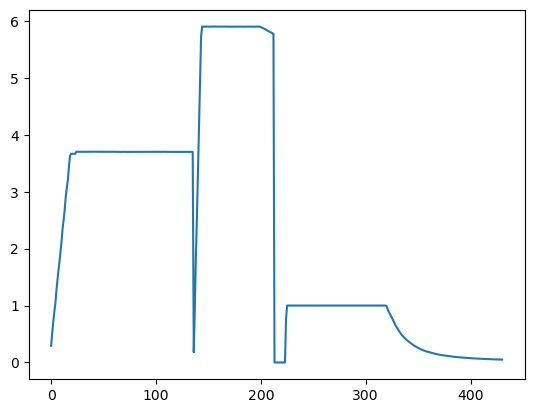

In [26]:
plt.plot(test_data[0]["Ic"][0])


**Normalization of the data (min max )**

In [27]:
cycle_dataset_df=train_data
minic=min(cycle_dataset_df[0]["Ic"][0])
maxic=max(cycle_dataset_df[0]["Ic"][0])
minid=min(cycle_dataset_df[0]["Id"][0])
maxid=max(cycle_dataset_df[0]["Id"][0])
minvc=min(cycle_dataset_df[0]["Vc"][0])
maxvc=max(cycle_dataset_df[0]["Vc"][0])
minvd=min(cycle_dataset_df[0]["Vd"][0])
maxvd=max(cycle_dataset_df[0]["Vd"][0])
mintc=min(cycle_dataset_df[0]["Tc"][0])
maxtc=max(cycle_dataset_df[0]["Tc"][0])
mintd=min(cycle_dataset_df[0]["Td"][0])
maxtd=max(cycle_dataset_df[0]["Td"][0])

for i in range(len(cycle_dataset_df)):
    for j in range(len(train_data[i])):
        if(min(cycle_dataset_df[i]["Ic"][j])<minic):
            minic=min(cycle_dataset_df[i]["Ic"][j])
        if(min(cycle_dataset_df[i]["Id"][j])<minid):
            minid=min(cycle_dataset_df[i]["Id"][j])

        if(max(cycle_dataset_df[i]["Ic"][j])>maxic):
            maxic=max(cycle_dataset_df[i]["Ic"][j])
        if(min(cycle_dataset_df[i]["Id"][j])>maxid):
            maxid=max(cycle_dataset_df[i]["Id"][j])


        if(min(cycle_dataset_df[i]["Vc"][j])<minvc):
            minvc=min(cycle_dataset_df[i]["Vc"][j])
        if(min(cycle_dataset_df[i]["Vd"][j])<minvd):
            minvd=min(cycle_dataset_df[i]["Vd"][j])
        if(max(cycle_dataset_df[i]["Vc"][j])>maxvc):
            maxvc=max(cycle_dataset_df[i]["Vc"][j])
        if(min(cycle_dataset_df[i]["Id"][j])>maxid):
            maxvd=max(cycle_dataset_df[i]["Vd"][j])


        if(min(cycle_dataset_df[i]["Tc"][j])<mintc):
            mintc=min(cycle_dataset_df[i]["Tc"][j])
        if(min(cycle_dataset_df[i]["Td"][j])<mintd):
            mintd=min(cycle_dataset_df[i]["Td"][j])
        if(max(cycle_dataset_df[i]["Vc"][j])>maxtc):
            maxtc=max(cycle_dataset_df[i]["Tc"][j])
        if(min(cycle_dataset_df[i]["Td"][j])>maxtd):
            maxtd=max(cycle_dataset_df[i]["Td"][j])

In [28]:
for i in range(len(cycle_dataset_df)):
    for j in range(len(cycle_dataset_df[i])):
        cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
        cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)

        cycle_dataset_df[i]["Vc"][j]=(cycle_dataset_df[i]["Vc"][j]-minvc)/(maxvc-minvc)
        cycle_dataset_df[i]["Vd"][j]=(cycle_dataset_df[i]["Vd"][j]-minvd)/(maxvd-minvd)

        cycle_dataset_df[i]["Tc"][j]=(cycle_dataset_df[i]["Tc"][j]-mintc)/(maxtc-mintc)
        cycle_dataset_df[i]["Td"][j]=(cycle_dataset_df[i]["Td"][j]-mintd)/(maxtd-mintd)
    

In [29]:
train_data=cycle_dataset_df

In [30]:
cycle_dataset_df=test_data
for i in range(len(cycle_dataset_df)):
    for j in range(len(cycle_dataset_df[i])):
        cycle_dataset_df[i]["Ic"][j]=(cycle_dataset_df[i]["Ic"][j]-minic)/(maxic-minic)
        cycle_dataset_df[i]["Id"][j]=(cycle_dataset_df[i]["Id"][j]-minid)/(maxid-minid)

        cycle_dataset_df[i]["Vc"][j]=(cycle_dataset_df[i]["Vc"][j]-minvc)/(maxvc-minvc)
        cycle_dataset_df[i]["Vd"][j]=(cycle_dataset_df[i]["Vd"][j]-minvd)/(maxvd-minvd)

        cycle_dataset_df[i]["Tc"][j]=(cycle_dataset_df[i]["Tc"][j]-mintc)/(maxtc-mintc)
        cycle_dataset_df[i]["Td"][j]=(cycle_dataset_df[i]["Td"][j]-mintd)/(maxtd-mintd)

In [31]:
test_data=cycle_dataset_df

In [32]:
min_max=np.array([minic,maxic,minid,maxid,minvc,maxvc,minvd,maxvd,mintc,maxtc,mintd,maxtd])

In [33]:
min_max

array([-12.16763636,   7.123479  , -12.16763636,  -0.56004351,
         2.0079174 ,   3.6014471 ,   1.9464617 ,   3.5845513 ,
        28.138685  ,  33.28050532,  28.03226953,  39.77749875])

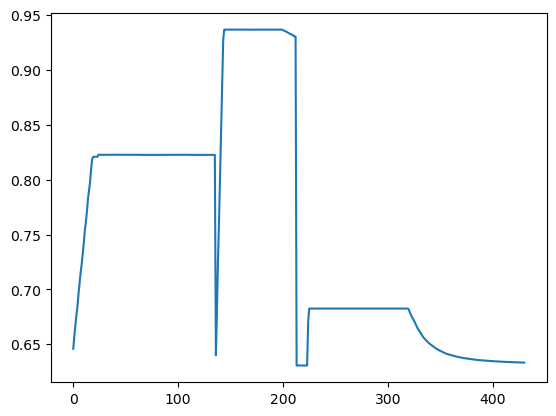

In [52]:
plt.plot(test_data[0]["Ic"][0])

In [35]:
np.save("min_max",min_max)

**For each cell we will get The inputs and the outputs for our model **

In [36]:
# split a univariate sequence into samples
def split_sequence(X,y,sequence, n_steps_in, n_steps_out):
 
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop(["SOH","charge_policy"],axis=1))
       y.append(seq_y["SOH"])
   return X, y

Split the data into train and test

In [37]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
for i in range(len(train_data)):
  X_train,Y_train=split_sequence(X_train,Y_train,train_data[i],10,10)
for i in range(len(test_data)):
  X_test,Y_test=split_sequence(X_test,Y_test,test_data[i],10,10)
  



In [38]:
np.shape(np.array(X_train[0]))

(10, 6)

In [61]:


X1=np.array(X_train)
Y1=np.array(Y_train)
X2=np.array(X_test)
Y2=np.array(Y_test)



In [40]:
r=425
for k in range(len(X1)):
    for i in range(10):
        for x in range(6):
             if(len(X1[k][i][x])>r):
                    r=len(X1[k][i][x])



In [41]:
r

848

In [ ]:
t=np.zeros((len(X1),10,6,848))
for k in range(len(X1)):
    for i in range(25):
        for x in range(6):
             for j in range(len(X1[k][i][x])):
                    if(j>=848):
                        break
                    else :
                            t[k][i][x][j]=X1[k][i][x][j]

In [59]:
X1=t

In [44]:
np.shape(X1)

(29212, 10, 6, 848)

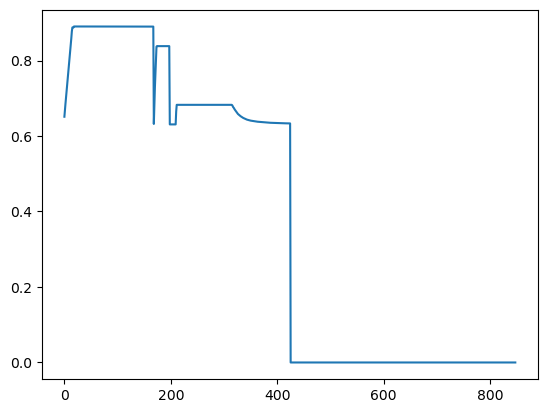

In [60]:
plt.plot(X1[0][0][0])

In [45]:
np.save("X1_10",X1)

In [46]:
t=np.zeros((len(X2),10,6,848))
for k in range(len(X2)):
    for i in range(10):
        for x in range(6):
             for j in range(len(X2[k][i][x])):
                    if(j>=848):
                        break
                    else :
                            t[k][i][x][j]=X2[k][i][x][j]

In [47]:
X2=t

In [48]:
X2.shape

(20929, 25, 6, 848)

In [49]:
np.save("X2_10",X2)


In [50]:

np.save("Y2_10",Y2)
np.save("Y1_10",Y1)
